In [4]:
import numpy
import moxa
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
print( 'TensorFlow %s' % tf.__version__ )
print( 'Keras %s' % tf.keras.__version__ )

TensorFlow 1.12.0
Keras 2.1.6-tf


## Synthesize Data

In [84]:
import thinkdsp

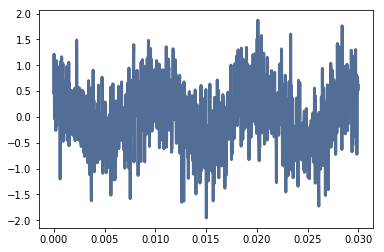

In [6]:
signal_cosine = thinkdsp.CosSignal( freq = 100, amp = 1.0, offset = 2 * numpy.pi * 0 )
wave = signal_cosine.make_wave( duration = 0.03, start = 0, framerate = 40000 )
noise_ratio = 1
wave.ys += numpy.random.standard_normal( wave.ys.shape ) * noise_ratio
wave.ys /= 1 + noise_ratio
segment = wave.segment( start = 0, duration = 1 )
segment.plot()

[(269.26488075653276, 99.99999999999999),
 (50.82653497557822, 1199.9999999999998),
 (40.9358688420616, 19233.333333333332),
 (39.032090315348476, 11433.333333333332),
 (38.365796449138685, 9699.999999999998),
 (37.793889555209276, 199.99999999999997),
 (36.71207038377518, 1866.6666666666665),
 (36.477564566847285, 9399.999999999998),
 (36.239336035966566, 19166.666666666664),
 (36.129866120762195, 19933.333333333332)]

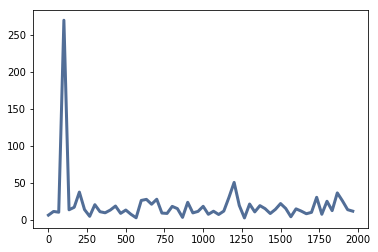

In [9]:
spectrum = wave.make_spectrum()
spectrum.plot( high = 2000 )
spectrum.peaks()[ : 10 ]

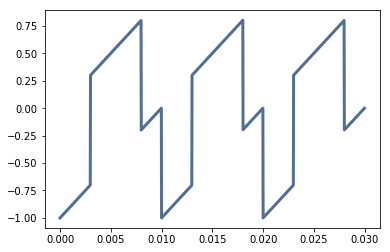

In [14]:
signal_sawtooth = thinkdsp.SawtoothSignal( freq = 100, amp = 1.0, offset = 2 * numpy.pi * 0 )
signal_square = thinkdsp.SquareSignal( freq = 100, amp = 1.0, offset = 2 * numpy.pi * 0.2 )
components = [ signal_sawtooth, signal_square ]
signal = thinkdsp.SumSignal( *components )
wave = signal.make_wave( duration = 0.03, start = 0, framerate = 40000 )
wave.ys = wave.ys / len( components )
segment = wave.segment( start = 0, duration = 1 )
segment.plot()

[(477.6227384641255, 99.99999999999999),
 (114.68186709729491, 499.99999999999994),
 (96.33997277767912, 199.99999999999997),
 (84.02474863498111, 299.99999999999994),
 (52.63287195593533, 899.9999999999999),
 (46.914558743470245, 399.99999999999994),
 (43.750484050214986, 1099.9999999999998),
 (38.21304017406545, 1499.9999999999998),
 (36.628499671500876, 699.9999999999999),
 (32.85992434516118, 599.9999999999999)]

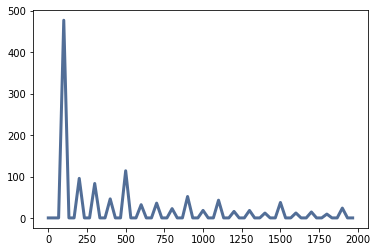

In [16]:
spectrum = wave.make_spectrum()
spectrum.plot( high = 2000 )
spectrum.peaks()[ : 10 ]

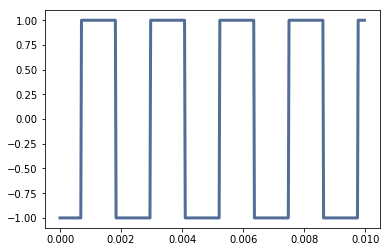

In [112]:
signal = thinkdsp.SquareSignal( freq = 440, amp = 1.0, offset = 2 * numpy.pi * 0.2 )
wave = signal.make_wave( duration = 1, start = 0, framerate = 44100 )
segment = wave.segment( start = 0, duration = 0.01 )
segment.plot()

[(28074.92977678068, 440.0),
 (9358.304099918221, 1320.0),
 (5614.9754691525095, 2200.0),
 (4010.6892735605925, 3080.0),
 (3119.417223046578, 3960.0),
 (2552.242511226125, 4840.0),
 (2159.5817510329416, 5720.0),
 (1871.6293618400884, 6600.0),
 (1651.4294480250635, 7480.0),
 (1477.586491072732, 8360.0)]

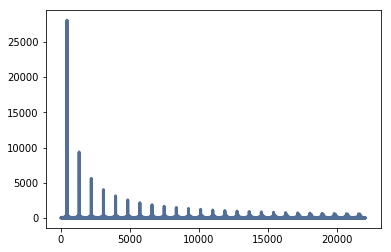

In [117]:
spectrum = wave.make_spectrum()
spectrum.plot(  )# high = 20000
spectrum.peaks()[ : 10 ]

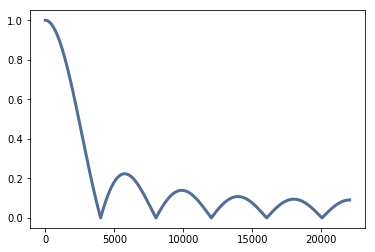

In [131]:
window = numpy.ones(11); window /= sum( window );
ys = wave.ys
padded = thinkdsp.zero_pad( window, len( ys ) )
wave.ys = padded
wave.make_spectrum().plot()

In [2]:
filename_data_x, filename_data_y = 'data_x.npy', 'data_y.npy'

In [3]:
# data_x, data_y = moxa.get_train_data( freq_lower = 10, freq_upper = 4000, freq_step = 1, n_offset = 10, shape_list = [ 'sawtooth', 'square', 'triangle' ] )
data_x, data_y = moxa.get_train_data_v3( n_offset = 10, shape_list = [ 'sawtooth', 'square', 'triangle', 'cosine' ] )
numpy.save( filename_data_x, data_x )
numpy.save( filename_data_y, data_y )

In [4]:
data_x = numpy.load( filename_data_x ); data_x = numpy.expand_dims( data_x, axis = 2 )
data_y = numpy.load( filename_data_y )
print( data_x.shape, data_y.shape )
print( data_y[ -50 : ] )

(85280, 4000, 1) (85280, 1)
[[5980]
 [5980]
 [5980]
 [5980]
 [5980]
 [5980]
 [5980]
 [5980]
 [5980]
 [5980]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]
 [5990]]


In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
shuffled_x, shuffled_y = shuffle( data_x, data_y )
x_train, x_valid, y_train, y_valid = train_test_split( shuffled_x, shuffled_y, test_size = 0.1, random_state = 42, stratify = shuffled_y )
#x_train, x_valid, y_train, y_valid = train_test_split( shuffled_x, shuffled_y, test_size = 0.1, random_state = 42 )
print( x_train.shape, y_train.shape, y_valid[:10] )

(76752, 4000, 1) (76752, 1) [[3714]
 [  77]
 [ 419]
 [3060]
 [1172]
 [5990]
 [1154]
 [ 410]
 [3030]
 [4248]]


## Model - CNN
### Todo: increase filter size to check if relevant to noise tolerance

In [6]:
template_model = models.Sequential()
template_model.add( layers.Conv1D( 32, [ 11 ], activation = 'relu', input_shape = [ 4000, 1 ] ) ) # padding = 'same'
# model.add( layers.MaxPooling1D( [ 2 ] ) )
template_model.add( layers.Conv1D( 32, [ 9 ], activation = 'relu' ) )
template_model.add( layers.Conv1D( 32, [ 7 ], activation = 'relu' ) )
template_model.add( layers.Conv1D( 32, [ 5 ], activation = 'relu' ) )
template_model.add( layers.Conv1D( 32, [ 3 ], activation = 'relu' ) )
template_model.add( layers.Flatten() )
# model.add( layers.Dense( 64, activation = 'relu' ) )
template_model.add( layers.Dense( 1, activation = None ) )
template_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3990, 32)          384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3982, 32)          9248      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3976, 32)          7200      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3972, 32)          5152      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3970, 32)          3104      
_________________________________________________________________
flatten (Flatten)            (None, 127040)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 127041    
Total para

## Training

In [7]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [ x.name for x in local_device_protos if x.device_type == 'GPU' ]
gpu_list = get_available_gpus()
n_gpu = len( gpu_list )
epochs = 100
batch_size = 32 * n_gpu
learning_rate = 0.0001
print( 'GPUs:', gpu_list )

GPUs: ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2']


In [8]:
from tensorflow.keras.utils import multi_gpu_model
template_model.compile( optimizer = optimizers.Adam( lr = learning_rate ), loss = 'mean_squared_error' )
parallel_model = multi_gpu_model( template_model, gpus = n_gpu )
parallel_model.compile( optimizer = optimizers.Adam( lr = learning_rate ), loss = 'mean_squared_error' )
history = parallel_model.fit( x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = ( x_valid, y_valid ) )
# model.compile( optimizer = optimizers.Adam( lr = learning_rate ), loss = 'mean_squared_error' )
# history = model.fit( x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = ( x_valid, y_valid ) )

Train on 76752 samples, validate on 8528 samples
Epoch 1/100
76752/76752 [==============================] - 20s 263us/step - loss: 716592.4197 - val_loss: 40492.4267
Epoch 2/100
76752/76752 [==============================] - 14s 188us/step - loss: 11378.8758 - val_loss: 3459.8421
Epoch 3/100
76752/76752 [==============================] - 14s 189us/step - loss: 2282.8059 - val_loss: 1419.6218
Epoch 4/100
76752/76752 [==============================] - 14s 189us/step - loss: 1058.7027 - val_loss: 795.5624
Epoch 5/100
76752/76752 [==============================] - 15s 190us/step - loss: 648.4700 - val_loss: 602.0706
Epoch 6/100
76752/76752 [==============================] - 14s 185us/step - loss: 376.6659 - val_loss: 388.5935
Epoch 7/100
76752/76752 [==============================] - 15s 190us/step - loss: 278.0350 - val_loss: 323.8035
Epoch 8/100
76752/76752 [==============================] - 14s 189us/step - loss: 210.1872 - val_loss: 128.9079
Epoch 9/100
76752/76752 [===================

76752/76752 [==============================] - 14s 188us/step - loss: 33.2799 - val_loss: 15.5278
Epoch 75/100
76752/76752 [==============================] - 15s 190us/step - loss: 41.8899 - val_loss: 12.2816
Epoch 76/100
76752/76752 [==============================] - 15s 192us/step - loss: 32.6117 - val_loss: 9.7548
Epoch 77/100
76752/76752 [==============================] - 15s 189us/step - loss: 68.8665 - val_loss: 9.1542
Epoch 78/100
76752/76752 [==============================] - 15s 191us/step - loss: 15.3530 - val_loss: 10.9158
Epoch 79/100
76752/76752 [==============================] - 14s 188us/step - loss: 49.3825 - val_loss: 32.9147
Epoch 80/100
76752/76752 [==============================] - 14s 188us/step - loss: 25.4759 - val_loss: 19.8431
Epoch 81/100
76752/76752 [==============================] - 15s 190us/step - loss: 33.4110 - val_loss: 8.9635
Epoch 82/100
76752/76752 [==============================] - 14s 187us/step - loss: 37.1144 - val_loss: 159.2056
Epoch 83/100
767

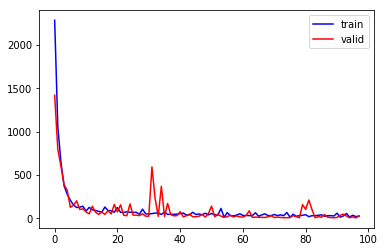

In [16]:
plotting_start_epoch = 2
train_loss_list = history.history[ 'loss' ][ plotting_start_epoch: ]
valid_loss_list = history.history[ 'val_loss' ][ plotting_start_epoch: ]
# ----------------------------- plot -------------------------------------------------
import matplotlib.pyplot as plt
plt.plot( numpy.arange( len( train_loss_list ) ), train_loss_list, 'b', label = 'train' )
plt.plot( numpy.arange( len( valid_loss_list ) ), valid_loss_list, 'r', label = 'valid' )
plt.legend()
plt.show()

In [17]:
from datetime import date
# template_model_path = '/data/sean/adc/saved_models/cnn_sawtooth_square_triangle_' + str( date.today() ) + '.h5'
template_model_path = '/data/sean/adc/saved_models/cnn_5l32k119753_sawtooth_square_triangle_cosine_10~6000_' + str( date.today() ) + '.h5'
template_model.save( template_model_path )
# parallel_model_path = '/data/sean/adc/saved_models/cnn_parallel_sawtooth_square_triangle_' + str( date.today() ) + '.h5'
# parallel_model.save( parallel_model_path )

## Testing
### todo: try using filter (boxcar, gaussian) before prediction

In [8]:
from tensorflow.keras import models
# template_model_path = '/data/sean/adc/saved_models/cnn_sawtooth_2019-03-06.h5'
# template_model_path = '/data/sean/adc/saved_models/cnn_sawtooth_square_triangle_2019-03-15.h5'
# template_model_path = '/data/sean/adc/saved_models/cnn_5l32k119753_sawtooth_square_triangle_cosine_10~6000_2019-03-22.h5'
template_model_path = '/data/sean/adc/saved_models/cnn_4l32k11_sawtooth_square_triangle_cosine_10~4000_2019-03-22.h5'
template_model = models.load_model( template_model_path )
# parallel_model_path = '/data/sean/adc/saved_models/cnn_parallel_sawtooth_square_triangle_2019-03-15.h5'
# parallel_model = models.load_model( parallel_model_path )

In [12]:
# test_x, test_y = moxa.get_test_data( freq = 1900, n_offset = 10, random_seed = 42, shape_list = [ 'sawtooth+square' ] )
test_x, test_y = moxa.get_test_data( freq = 1000, n_offset = 10, random_seed = 42, noise_ratio = 1,
                                     shape_list = [ 'sawtooth' ] )
test_x_filtered = moxa.filter_data_batch( test_x, std = 5 )
test_x = numpy.expand_dims( test_x, axis = 2 )
test_x_filtered = numpy.expand_dims( test_x_filtered, axis = 2 )
print( test_x_filtered.shape, test_y.shape, test_y[ 0 ] )

(10, 4000, 1) (10, 1) [1000]


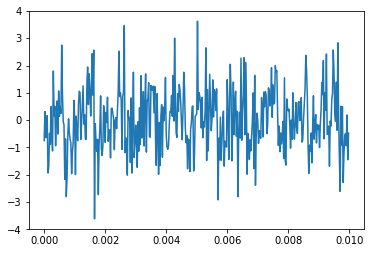

In [33]:
import matplotlib.pyplot as plt
y = numpy.squeeze( test_x[ 0 ], axis = 1 )[ : 400 ]
x = [ i for i in numpy.arange( 0, 0.01, 0.01 / len( y ) ) ]
plt.plot( x, y )

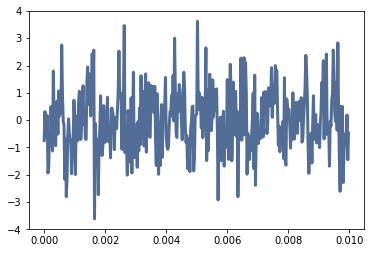

In [36]:
import thinkdsp
test_wave = thinkdsp.Wave( test_x[ 0 ], framerate = 40000 )
test_wave.segment( start = 0, duration = 0.01 ).plot()

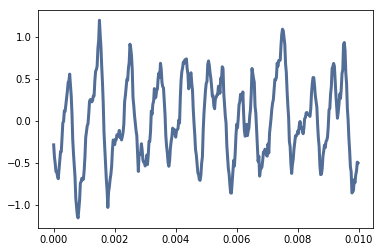

In [37]:
test_wave = thinkdsp.Wave( test_x_filtered[ 0 ], framerate = 40000 )
test_wave.segment( start = 0, duration = 0.01 ).plot()

In [38]:
print( 'Source:', test_y[ 0 ] )
print( 'Predictions (raw):', template_model.predict( test_x ) )
print( 'RMSE:', numpy.sqrt( template_model.evaluate( test_x, test_y ) ) )
print( 'Predictions (filtered):', template_model.predict( test_x_filtered ) )
print( 'RMSE:', numpy.sqrt( template_model.evaluate( test_x_filtered, test_y ) ) )

Source: [1000]
Predictions (raw): [[2738.023 ]
 [2852.1814]
 [2824.2527]
 [2776.4138]
 [2759.1558]
 [2820.4277]
 [2745.7036]
 [2810.105 ]
 [2878.412 ]
 [2713.6067]]
10/10 [==============================] - 0s 407us/step
RMSE: 1792.5476981101508
Predictions (filtered): [[1003.94586]
 [1039.4014 ]
 [1044.8867 ]
 [1026.1289 ]
 [1035.9669 ]
 [1060.1322 ]
 [1042.4722 ]
 [1030.9575 ]
 [1056.9282 ]
 [1035.1356 ]]
10/10 [==============================] - 0s 374us/step
RMSE: 40.51254417278138


## Trial Run

In [118]:
pool = models.Sequential()
pool.add( layers.MaxPooling1D( pool_size = [ 4 ], input_shape = [ 4, 4 ] ) )
pool.predict( sample )

array([[[2., 3., 4., 5.]]], dtype=float32)